# **Background**

Welcome to the C4AI Scholars Program Take-Home Challenge! This exercise is designed to allow you to showcase your engineering and problem solving skills. The Challenge consists of different challenges including:

*   Identifying bugs, and getting the code working. This is designed to test your ability to grapple with real world engineering challenges.
*   Testing your ability to generate code for a specified problem.
*   An opportunity for you to attempt an optional challenge question that extends the original problem set.

These tasks were chosen as a setting to see how you think about problems, even if they are not in your own research field of interest. The tasks and dataset are not meant to be indicative of the research goals of the Scholar Program. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources (can be run in this colab).

Good luck!

**How to Use and Submit this Document?**

*   **Make a copy of this document** and rename it **Firstname_Lastname_C4AIScholarsChallenge**
*   Once you have completed all tasks, save and pin your revisions
*   Submit the assignment by responding directly to the email you received (please reply all) with a link to your final document by Monday October 2nd at 1pm PST.

# **Universal sentence embeddings background [2 points]**
In this takehome, we will be exploring different ways of learning sentence embeddings. Sentence embedding is the collective name for a set of techniques in natural language processing (NLP) where sentences are mapped to vectors of real numbers. For an overview of sentence embeddings and some common methods, we refer these articles: [link1](https://txt.cohere.com/sentence-word-embeddings/), [link2](https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a)  

Q1: What are some real world applications of dense sentence embeddings?

Answer: Some real-world applications of dense sentence embeddings include machine translation systems and semantic search engines. Dense embeddings play a crucial role in machine translation systems like Google Translate as they help capture the meaning of sentences in one language and enable accurate translation into another language. Meanwhile, search engines, such as Google, use dense embeddings to enhance semantic search. By representing documents and user queries in a common embedding space, search engines can find semantically similar documents, even if the exact keywords don't match.

Q2: Apart from using large language models, what are other ways to compute sentence embeddings?

Answer: Another way of computing sentence embeddings is to take pretrained dense word embeddings created using another technique, such as Word2Vec, GloVe or FastText, or pretrained sparse embeddings created using techniques like TF-IDF or PPMI and compute the embeddings for a sentence by averaging the embeddings for each of the words in the sentence. The main drawback of this however is that these embeddings will not take into account positional information for the words in the sentence.

**Imports**

In [ ]:
import json
import math
from collections import OrderedDict
import torch
from torch import nn, Tensor
from typing import Union, Tuple, List, Iterable, Dict
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import AdamW
from torch.utils.data import DataLoader
from scipy.stats import pearsonr, spearmanr
import numpy as np
import gzip, csv
import pandas as pd
from tqdm.auto import tqdm

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
%pip install transformers
from transformers import AutoTokenizer
# If you can not find all the bugs, use the line below for AutoModel
# from transformers import AutoModel

## **Coding Challenge Part 1: Debugging custom BERT code [7 points]**

BERT ([Bidirectional Encoder Representations from Transformers](https://arxiv.org/abs/1810.04805)) is a transformer based language model that is pretrained to generate contextualized embeddings. In this part, we provide a BERT implementation together with a pretrained checkpoint file. This BERT implementation includes 7 bugs in which some of these bugs break the code but some of them only impact the model performance.

Tasks:
* [**7 points**] Your goal is to get the code working. There are 7 bugs in the code, some of them lead to error in the code but some of them are designed to impair test accuracy but not break the code. You will one point for each of the 7 bugs you find.

* [**1 points**] We will give extra points for also adding improved documentation to each of the functions we introduce in this section, and for describing the fixes to the bugs.


Note for usage and comparison:
*   In order to test this implementation, we provide ***bert_tiny.bin*** and example usage in the below cells.
*   You can check if your bugfixes are correct based on your results in "Coding challenge Part 2". Except the Bert imlementation, there is no bugs in other parts, so if your fixes are correct you should achieve the same results. We provide the expected results for you to compare.


**Please DO NOT use any additional library except the ones that are imported!!**

In [ ]:
def gelu(x):
    """
    Compute the Gaussian Error Linear Unit (GELU) activation function.

    :param x: The input tensor.

    :return: The tensor after applying the GELU activation function element-wise.
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

class Config(object):
    """
    Create an instance of the Config class to configure the BERT model's
    hyperparameters
    """

    def __init__(self,
                vocab_size,
                hidden_size=768,
                num_hidden_layers=12,
                num_attention_heads=12,
                intermediate_size=3072,
                dropout_prob=0.9,
                max_position_embeddings=512,
                type_vocab_size=2,
                initializer_range=0.02):
        """
        Initialize an instance of Config.

        :param vocab_size: The size of the vocabulary.
        :param hidden_size: The dimensionality of the hidden states.
        :param num_hidden_layers: The total number of transformer layers.
        :param num_attention_heads: The number of attention heads in each multi-head
                                    self-attention mechanism
        :param intermediate_size: The size of the intermediate feed-forward layer
                                  within each transformer layer.
        :param dropout_prob: The probability of dropout applied to the model's
                             hidden states and attention scores during training.
        :param max_position_embeddings: The maximum length of input sequences
                                        (in terms of tokens) that the model can handle.
        :param type_vocab_size: The size of the token type vocabulary.
        :param initializer_range: The range for initializing model parameters.
                                  It specifies the bounds for random initialization
                                  of model weights.
        """

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = dropout_prob
        self.attention_probs_dropout_prob = dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range

    @classmethod
    def from_dict(cls, dict_object):
        """
        Method to load a configuration from a dictionary.

        :param dict_object: Dictionary containing configuration settings.

        :return: Config object populated using the contents of dict_object.
        """

        config = Config(vocab_size=None)
        for (key, value) in dict_object.items():
            config.__dict__[key] = value
        return config


class LayerNorm(nn.Module):
      """
      Implements layer normalization with learnable parameters (gamma and beta).
      """

      def __init__(self, hidden_size, variance_epsilon=1e-12):
        """
        Initialize a LayerNorm module.

        :param hidden_size: The dimensionality of the input feature vectors.
        :param variance_epsilon: A small constant added to the denominator for
                                 numerical stability during normalization.
        """

        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon

      def forward(self, x):
        """
        Apply layer normalization to the input tensor.

        :param x: The input tensor of shape (batch_size, sequence_length, hidden_size)

        :return: The normalized output tensor of the same shape as the input.
        """

        ## BUG 1 & 2 - Firstly, we should be calculating the feature-wise mean of x.
        ## However, the dimension the mean was calculated along here was incorrect
        ## (0 instead of 2)

        ## Additionally, the signs for both of the equations being computed below were
        ## incorrect. s = (x + u).pow(2).mean(0, keepdim=True) should be calculating
        ## the variance, however this equation is wrong. Should be
        ## s = (x - u).pow(2).mean(2, keepdim=True)

        ## Meanwhile, x = (x + u) / torch.sqrt(s + self.variance_epsilon) is incorrect
        ## relative to the equation for computing layer normalisation.
        ## Should be x = (x - u) / torch.sqrt(s + self.variance_epsilon).
        u = x.mean(2, keepdim=True)
        s = (x - u).pow(2).mean(2, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)

        return self.gamma * x + self.beta


class MLP(nn.Module):
      """
      Multi-Layer Perceptron (MLP) module used within BERT model. The MLP consists
      of two linear transformations with a GELU activation function
      applied in between.
      """

      def __init__(self, hidden_size, intermediate_size):
        """
        Initialize a Multi-Layer Perceptron (MLP) module.

        :param hidden_size: The input and output dimension of the MLP.
        :param intermediate_size: The dimension of the intermediate (hidden) layer.
        """

        super(MLP, self).__init__()
        self.dense_expansion = nn.Linear(hidden_size, intermediate_size)
        self.dense_contraction = nn.Linear(intermediate_size, hidden_size)

      def forward(self, x):
        """
        Forward pass of the MLP module.

        :param x: The input tensor of size (batch_size, hidden_size)

        :return: The output tensor after applying the MLP, with the same shape
                 as the input.
        """

        x = self.dense_expansion(x)
        x = self.dense_contraction(gelu(x))
        return x


class Layer(nn.Module):
    """
    Transformer layer used in BERT model.
    """

    def __init__(self, config):
        """
        Initialize a Transformer Layer module.

        :param config: An instance of the Config class containing layer-specific
                       hyperparameters.
        """

        super(Layer, self).__init__()

        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

        self.attn_out = nn.Linear(config.hidden_size, config.hidden_size)
        self.ln1 = LayerNorm(config.hidden_size)

        self.mlp = MLP(config.hidden_size, config.intermediate_size)
        self.ln2 = LayerNorm(config.hidden_size)

    def split_heads(self, tensor, num_heads, attention_head_size):
        """
        Split a 3D tensor into multiple heads for multi-head attention.

        :param tensor: The input tensor of shape (batch_size, sequence_length, hidden_size).
        :param num_heads: The number of attention heads.
        :param attention_head_size: The size of each attention head.

        :return: The tensor with shape (batch_size, num_heads, sequence_length, attention_head_size).
        """

        new_shape = tensor.size()[:-1] + (num_heads, attention_head_size)
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)

    def merge_heads(self, tensor, num_heads, attention_head_size):
        """
        Merge multiple heads back into a single tensor.

        :param tensor: The input tensor with shape (batch_size, num_heads, sequence_length, attention_head_size).
        :param num_heads: The number of attention heads.
        :param attention_head_size: The size of each attention head.

        :return: The tensor with shape (batch_size, sequence_length, hidden_size).
        """

        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attention_head_size,)
        return tensor.view(new_shape)

    def attn(self, q, k, v, attention_mask):
        """
        Compute scaled dot-product attention.

        :param q: The query tensor.
        :param k: The key tensor.
        :param v: The value tensor.
        :param attention_mask: The attention mask tensor.

        :return: The attention tensor.
        """

        mask = attention_mask == 1
        mask = mask.unsqueeze(1).unsqueeze(2)

        ## BUG 3 - Based on equation for computing the attention score (dot product)
        ## s should equal QK^T where K^T is the transpose of K. Meanwhile,
        ## the previous line of code is doing QK, throwing a
        ## dimensionality error: s = torch.matmul(q, k)
        ## Corrected below, with the transpose applied to the last two dimensions
        ## of K
        s = torch.matmul(q, k.transpose(-1, -2))

        s = s / math.sqrt(self.attention_head_size)

        ## BUG 4 - Values should be masked using a value of -inf, not inf.
        ## This is because the purpose of the mask is to force the transformer
        ## to ignore the attention scores for the masked values.
        ## Setting to positive infinity does the opposite and causes
        ## numerical instability
        s = torch.where(mask, s, torch.tensor(float('-inf')))

        ## BUG 5 - Here, once the attention scores have been calculated and
        ## masked, we should then apply the softmax function. This serves
        ## to normalise the attention scores, and without this we see
        ## numerical instability i.e. nan values
        p = F.softmax(s, dim=-1)
        p = self.dropout(p)

        a = torch.matmul(p, v)
        return a

    def forward(self, x, attention_mask):
        """
        Forward pass of the Transformer Layer module.

        :param x: The input tensor
        :param attention_mask: The attention mask tensor.

        :return: The output tensor after processing through the layer, with the
                 same shape as the input.
        """

        q, k, v = self.query(x), self.key(x), self.value(x)

        q = self.split_heads(q, self.num_attention_heads, self.attention_head_size)
        k = self.split_heads(k, self.num_attention_heads, self.attention_head_size)
        v = self.split_heads(v, self.num_attention_heads, self.attention_head_size)

        a = self.attn(q, k, v, attention_mask)
        a = self.merge_heads(a, self.num_attention_heads, self.attention_head_size)
        a = self.attn_out(a)

        ## BUG 6 - Residual connections are required for self-attention and the MLP.
        ## Residual connections make it easier to train complex neural networks
        ## by allowing a given layer to establish relationships among
        ## the input words without having to preserve the information encoded
        ## in the word/position embedding
        a += x   ## Residual connection
        a = self.dropout(a)
        a = self.ln1(a)

        m = self.mlp(a)
        m += a   ## Residual connection
        m = self.dropout(m)
        m = self.ln2(m)

        return m

class Bert(nn.Module):
      """
      BERT (Bidirectional Encoder Representations from Transformers) model for
      natural language understanding tasks.
      """

      def __init__(self, config_dict):
        """
        Initialize a BERT (Bidirectional Encoder Representations from
        Transformers) model.

        :param config_dict: A dictionary containing BERT configuration settings.
        """

        super(Bert, self).__init__()
        self.config = Config.from_dict(config_dict)
        self.embeddings = nn.ModuleDict({
          'token': nn.Embedding(self.config.vocab_size, self.config.hidden_size, padding_idx=0),
          'position': nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size),
          'token_type': nn.Embedding(self.config.type_vocab_size, self.config.hidden_size),
        })

        self.ln = LayerNorm(self.config.hidden_size)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)

        self.layers = nn.ModuleList([
            Layer(self.config) for _ in range(self.config.num_hidden_layers)
        ])

        self.pooler = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.config.hidden_size, self.config.hidden_size)),
            ('activation', nn.Tanh()),
        ]))

      def forward(self, input_ids, attention_mask=None, token_type_ids=None, ):
        """
        Forward pass of the BERT model.

        :param input_ids: The input token IDs of shape (batch_size, sequence_length).
        :param attention_mask: The attention mask tensor of shape (batch_size, sequence_length).
        :param token_type_ids: The token type IDs to distinguish between different segments
                               of shape (batch_size, sequence_length).

        :return: A tuple containing the output tensor of shape (batch_size, sequence_length, hidden_size)
                 and the pooled representation of shape (batch_size, hidden_size).
        """

        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        ## BUG 7 - This is not how the input embedding should be generated. Torch.cat
        ## concatenates the embeddings for the input tokens, their corresponding
        ## positional embeddings and the token type embeddings, changing the dimensionality
        ## of the input embedding vector unnecessarily - being hidden_size * 3 along the
        ## feature dimension. We should be adding the values of the embeddings together
        ## to compute the input embeddings as well as preserve dimensionality
        # x = torch.cat((self.embeddings.token(input_ids),
        #                self.embeddings.position(position_ids),
        #                self.embeddings.token_type(token_type_ids)),
        #               dim=-1)

        x = self.embeddings.token(input_ids) + self.embeddings.position(position_ids) + self.embeddings.token_type(token_type_ids)

        x = self.dropout(self.ln(x))

        for layer in self.layers:
            x = layer(x, attention_mask)

        o = self.pooler(x[:, 0])
        return (x, o)

      def load_model(self, path):
        """
        Load pre-trained model weights from a specified file path.

        :param path: The path to the model checkpoint file.

        :return: The loaded model.
        """

        self.load_state_dict(torch.load(path))
        return self

**Download weights for the custom Bert**

In [ ]:
!wget https://github.com/for-ai/bert/raw/master/bert_tiny.bin

--2023-10-02 15:36:40--  https://github.com/for-ai/bert/raw/master/bert_tiny.bin
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin [following]
--2023-10-02 15:36:41--  https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17555010 (17M) [application/octet-stream]
Saving to: ‘bert_tiny.bin.3’

bert_tiny.bin.3     100%[===================>]  16.74M  --.-KB/s    in 0.1s    

2023-10-02 15:36:42 (162 MB/s) - ‘bert_tiny.bin.3’ saved [17555010/17555010]



**An example use of pretrained BERT with transformers library to encode a sentence**

In [ ]:
MODEL_NAME = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

## IF YOU CANNOT SOLVE PREVIOUS BUGS, USE THE LINE BELOW:
## bert = AutoModel.from_pretrained(MODEL_NAME)

bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')

#EXAMPLE USE
sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
output = bert(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)

# We use "pooler_output" for simplicity. This corresponds the last layer
# hidden-state of the first token of the sequence (CLS token) after
# further processing through the layers used for the auxiliary pretraining task.
embedding = output[1]
print(f'\nResulting embedding shape: {embedding.shape}')


Resulting embedding shape: torch.Size([1, 128])


# **Coding Challenge Part 2: Evaluate a pretrained BERT model on STS benchmark [4 points]**

**Please do not use additional library except the ones that are imported!!**

In this part, we are going to evaluate a pretrained BERT model on STS benchmark without applying any additional training. For the evaluation we provide Pearson/Spearman correlation functions and cosine similarity method.

Tasks:

*   **[2 Points]** Prepare an evaluation data loader and evaluation loop: Read in the STS data, tokenize it as shown in the example,  generate the dataloader and return Pearson and Spearman correlation scores.
*   **[1 Point]** Implement cosine similarity function, explained as TODO

**[1 Point] Question**: What is the difference between Pearson and Spearman correlation, and why you might want to evaluate using both metrics?

Answer: Pearson correlation measures the linear relationship between two continuous variables, and it assumes that the variables have a linear association and are normally distributed. On the other hand, Spearman correlation evaluates the monotonic relationship between variables via calculating the Pearson correlation on the ranks of the data, making it suitable for both continuous and ordinal data, and it doesn't rely on the assumption of linearity or normality. Evaluating using both metrics can be valuable because they capture different aspects of the relationship between variables. Pearson is sensitive to linear relationships, while Spearman can detect monotonic but nonlinear associations. Using both metrics provides a more comprehensive understanding of the data, ensuring that the analysis isn't limited to linear correlations and is robust to potential outliers or non-normally distributed data.

**Semantic Textual Similarity (STS) benchmark:**
STS dataset consists of a set of sentence pairs with a semantic similarity scores for each pair. We want to use this dataset to evaluate the quality of a sentence encoder.

Dataset includes:

*   Sentence pair: (sentence1, sentence2)
*   Similarity score: ranging 1 to 5 where 5 corresponds highest similarity
*   Splits: train, dev, test

**Download datasets**

In [ ]:
!wget https://sbert.net/datasets/stsbenchmark.tsv.gz

--2023-10-02 15:36:43--  https://sbert.net/datasets/stsbenchmark.tsv.gz
Resolving sbert.net (sbert.net)... 104.21.67.200, 172.67.180.145, 2606:4700:3031::ac43:b491, ...
Connecting to sbert.net (sbert.net)|104.21.67.200|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz [following]
--2023-10-02 15:36:43--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392336 (383K) [application/octet-stream]
Saving to: ‘stsbenchmark.tsv.gz.3’

stsbenchmark.tsv.gz 100%[===================>] 383.14K   649KB/s    in 0.6s    

In [ ]:
data = pd.read_csv('stsbenchmark.tsv.gz', nrows=5, compression='gzip', delimiter='\t', quoting=csv.QUOTE_NONE)
data.head()

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


In [ ]:
def load_sts_dataset(file_name):
  # DONE: add code to load STS dataset in required format

  # Defining the columns we wish to select. In this case, we want all the
  # sentence pairs for the 'test' split, so we need columns split, sentence1,
  # sentence2 and score
  selected_columns = ['split', 'score', 'sentence1', 'sentence2']

  # Defining the data split we wish to extract from the dataset
  desired_split = 'test'

  # Read the CSV file and select specific columns
  data = pd.read_csv(file_name, compression='gzip', delimiter='\t',
                     quoting=csv.QUOTE_NONE,
                     usecols=selected_columns)

  # Filter rows where the 'split' column matches desired_split
  filtered_data = data[data['split'] == desired_split]

  # Initialise dictionary for storing the test samples
  sts_samples = {'test': []}

  # Iterate through the rows of the DataFrame
  for index, row in filtered_data.iterrows():
    sentence1 = row['sentence1']
    sentence2 = row['sentence2']
    score = row['score']

    # Create a tuple in the format (sentence1, sentence2, score)
    sample = (sentence1, sentence2, score)

    # Append the tuple to the 'test' key in the dictionary
    sts_samples['test'].append(sample)

  return sts_samples

def tokenize_sentence_pair_dataset(dataset, tokenizer, max_length=512):
  # DONE: add code to generate tokenized version of the dataset

  # Based on the implementation of load_sts_dataset()/load_nli_dataset(), 'dataset' will
  # be in the form (sentence1, sentence2, label) for each pair of sentences

  # The Dataloader object typically takes as its input a list of dictionaries,
  # where each dictionary represents a given datapoint. Thus, here we must create
  # a dictionary for each item in dataset and store all the dictionaries
  # in a list

  # Each dictionary will store the input data in the format:
  # {
  #   sentence1_input_ids: The first sentence's input ids,
  #   sentence1_attention_mask: The first sentence's attention mask
  #   sentence2_input_ids: The second sentence's input ids,
  #   sentence2_attention_mask: The second sentence's attention mask
  #   label: The associated label for the sentence pair. For the sts dataset this
  #          will be the score but for the nti dataset it will be the label e.g.
  #          neutral, entailment, etc
  # }

  # Create list for storing dictionaries
  tokenized_dataset = []

  # Iterate through data and create dictionaries
  for sentence1, sentence2, label in dataset:
    # Tokenize each sentence
    sentence1_tokenized = tokenizer(sentence1, return_tensors='pt',
                                    padding='max_length',
                                    max_length=max_length)

    sentence2_tokenized = tokenizer(sentence2, return_tensors='pt',
                                    padding='max_length',
                                    max_length=max_length)

    # Create a dictionary for results of tokenization for each data sample
    sample_dict = {
        'sentence1_input_ids': sentence1_tokenized['input_ids'].tolist(),
        'sentence1_attention_mask': sentence1_tokenized['attention_mask'].tolist(),
        'sentence2_input_ids': sentence2_tokenized['input_ids'].tolist(),
        'sentence2_attention_mask': sentence2_tokenized['attention_mask'].tolist(),
        'label': label
    }

    # Append the dictionary to the list
    tokenized_dataset.append(sample_dict)

  return tokenized_dataset


def get_dataloader(tokenized_dataset, batch_size, shuffle=False, collate_fn=None):
    if collate_fn is None:
        # If custom_collate_fn is not provided, use the default collate function
        return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle)
    return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)


def cosine_sim(a, b):
  # DONE: Implement cosine similarity function **from scrach**:
  # This method should expect two 2D matrices (batch, vector_dim) and
  # return a 2D matrix (batch, batch) that contains all pairwise cosine similarities

  # Compute the dot product between a and b
  # Must transpose b to ensure that dimensions match for matrix multiplication
  dot_product = torch.mm(a, b.t())

  # Compute the Euclidean norm of a and b for each row (since each row
  # will be an item from the batch). Thus, both norm_a and norm_b
  # will be 1D tensors of size (batch,)
  norm_a = torch.norm(a, dim=1)
  norm_b = torch.norm(b, dim=1)

  # Compute the cosine similarity by dividing the dot product by the product of norms.
  # We use slicing here to ensure that norm_a and norm_b have the same dimensions
  # to facilitate element-wise multiplication between them. The result of
  # element-wise multiplication will be a matrix of size (batch, batch) - which
  # we can then divide the dot_product matrix by
  similarity = dot_product / (norm_a[:, None] * norm_b[None, :])
  return similarity


def eval_loop(model, eval_dataloader, device):
  #DONE: add code to for evaluation loop
  #DONE: Use cosine_sim function above as distance metric for pearsonr and spearmanr functions that are imported

  # Initialize lists to store cosine similarities and scores from sts dataset
  cosine_sims = []
  scores = []

  # Set the model in evaluation mode (no gradient calculation)
  model.eval()

  # Iterate through the evaluation dataloader
  for batch in eval_dataloader:
    # Extract data for sentence pair
    sentence1_input_ids = torch.tensor(batch['sentence1_input_ids']).to(device)
    sentence1_attention_mask = torch.tensor(batch['sentence1_attention_mask']).to(device)
    sentence2_input_ids = torch.tensor(batch['sentence2_input_ids']).to(device)
    sentence2_attention_mask = torch.tensor(batch['sentence2_attention_mask']).to(device)
    score = batch['label'].item()

    # Forward pass through the model to obtain embeddings
    sentence1_embeddings = model(input_ids=sentence1_input_ids,
                        attention_mask=sentence1_attention_mask)

    sentence2_embeddings = model(input_ids=sentence2_input_ids,
                        attention_mask=sentence2_attention_mask)

    # Calculate cosine similarities between pairs of embeddings. We use the
    # pooler output to represent each sentence
    cosine_similarity = cosine_sim(sentence1_embeddings[1], sentence2_embeddings[1]).item()

    # Store cosine similarity and its corresponding sts score
    cosine_sims.append(cosine_similarity)
    scores.append(score)

  # Calculate Pearson and Spearman correlations
  cosine_sims = np.array(cosine_sims, dtype=np.float64)
  scores = np.array(scores, dtype=np.float64)

  eval_pearson_cosine, _ = pearsonr(cosine_sims, scores)
  eval_spearman_cosine, _ = spearmanr(cosine_sims, scores)
  return [eval_pearson_cosine, eval_spearman_cosine]

**Evaluation**

Expected result:

Pearson correlation: 0.32

Spearman correlation: 0.33

In [ ]:
#INFO: model and tokenizer
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

#INFO: load bert
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')

#INFO: load dataset
sts_dataset = load_sts_dataset('stsbenchmark.tsv.gz')

#INFO: tokenize dataset
tokenized_test = tokenize_sentence_pair_dataset(sts_dataset['test'], tokenizer)

#INFO: generate dataloader
test_dataloader = get_dataloader(tokenized_test, batch_size=1)

#INFO: run evaluation loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
results_from_pretrained = eval_loop(bert, test_dataloader, device)

print(f'\nPearson correlation: {results_from_pretrained[0]:.2f}\nSpearman correlation: {results_from_pretrained[1]:.2f}')


Pearson correlation: 0.32
Spearman correlation: 0.33


# **Coding Challenge Part 3: Learning sentence embeddings using Natural Language Inference (NLI) dataset [4 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

[Conneue et al. (2018)](https://https://arxiv.org/pdf/1705.02364.pdf) showed that a good sentence embedding model can be learned using NLI dataset. This method proposes using a shared encoder to encode both premise and hypothesis and then combine them before using a softmax classifier. Here , we will use a pretrained BERT model as shared encoder.  

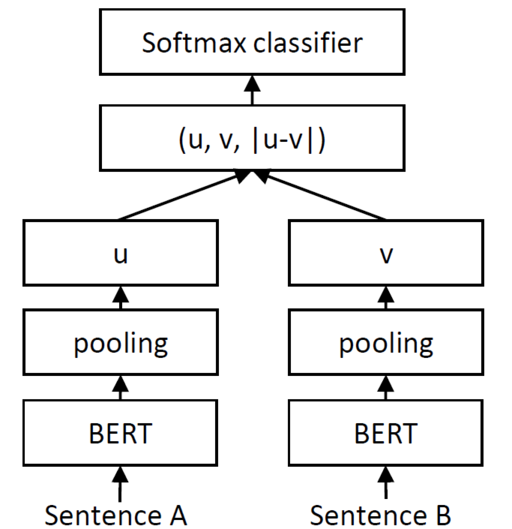

Tasks:

*   **[2 Point]** Prepare a training dataloader and training loop: Read in NLI data, tokenize and generate the corresponding data loader
*   **[2 Point]** BertClassifier: Construct a model that uses above method. Please follow the architecture illustrated in the given figure.

**Download NLI dataset**

This dataset includes:
*   Sentence pairs: (sentence1, sentence2)
*   Label: (contradiction, entailment, neutral)
*   Split: train, dev, test

In [ ]:
!wget 'https://sbert.net/datasets/AllNLI.tsv.gz'

--2023-10-02 15:39:29--  https://sbert.net/datasets/AllNLI.tsv.gz
Resolving sbert.net (sbert.net)... 172.67.180.145, 104.21.67.200, 2606:4700:3031::ac43:b491, ...
Connecting to sbert.net (sbert.net)|172.67.180.145|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz [following]
--2023-10-02 15:39:29--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40794454 (39M) [application/octet-stream]
Saving to: ‘AllNLI.tsv.gz.3’

AllNLI.tsv.gz.3     100%[===================>]  38.90M  13.7MB/s    in 2.8s    

2023-10-02 15:39:33 

In [ ]:
data = pd.read_csv('AllNLI.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,dataset,filename,sentence1,sentence2,label
0,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,train,SNLI,snli_1.0_train,Children smiling and waving at camera,They are smiling at their parents,neutral
4,train,SNLI,snli_1.0_train,Children smiling and waving at camera,There are children present,entailment


In [ ]:
def load_nli_dataset(file_name):
  #DONE: add code to load NLI dataset in required format

  # Defining the columns we wish to select. In this case, we want all the
  # sentence pairs for the 'train' split, so we need columns split, sentence1,
  # sentence2 and label
  selected_columns = ['split', 'label', 'sentence1', 'sentence2']

  # Defining the data split we wish to extract from the dataset
  desired_split = 'train'

  # Read the CSV file and select specific columns
  data = pd.read_csv(file_name, compression='gzip', delimiter='\t',
                     quoting=csv.QUOTE_NONE,
                     usecols=selected_columns)

  # Filter rows where the 'split' column matches desired_split
  filtered_data = data[data['split'] == desired_split]

  # Initialise dictionary for storing the training samples
  nli_samples = {'train': []}

  # Iterate through the rows of the DataFrame
  for index, row in filtered_data.iterrows():
    sentence1 = row['sentence1']
    sentence2 = row['sentence2']
    label = row['label']

    # Create a tuple in the format (sentence1, sentence2, label)
    sample = (sentence1, sentence2, label)

    # Append the tuple to the 'train' key in the dictionary
    nli_samples['train'].append(sample)

  return nli_samples

def create_one_hot_encoding(label_values):
  # Helper fn to create a dictionary to map label values to one-hot vectors.

  num_labels = len(label_values)
  one_hot_encoding = {}

  for i, label in enumerate(label_values):
      one_hot_vector = [0] * num_labels
      one_hot_vector[i] = 1
      one_hot_encoding[label] = one_hot_vector

  return one_hot_encoding

# Computing the one_hot_encoding dictionary based on the num of labels
label_values = ['neutral', 'contradiction', 'entailment']
one_hot_encoding = create_one_hot_encoding(label_values)

# A helper function passed to the dataloader to create batch matrices in the form
# (batch_size, sequence_length) for sentence1_input_ids, sentence1_attention_mask,
# sentence2_input_ids and sentence2_attention_mask. The 1-hot encodings for the
# labels are computed and stored in the shape (batch_size, num_labels)
def custom_collate_fn(batch):
  # 'batch' is the list of dictionaries for a given batch

  # Extract individual lists of input_ids and attention_mask for each sample in the batch
  sentence1_input_ids = [sample['sentence1_input_ids'][0] for sample in batch]
  sentence1_attention_mask = [sample['sentence1_attention_mask'][0] for sample in batch]
  sentence2_input_ids = [sample['sentence2_input_ids'][0] for sample in batch]
  sentence2_attention_mask = [sample['sentence2_attention_mask'][0] for sample in batch]

  # Convert input_ids and attention_mask to tensor
  sentence1_input_ids = torch.tensor(sentence1_input_ids)
  sentence1_attention_mask = torch.tensor(sentence1_attention_mask)
  sentence2_input_ids = torch.tensor(sentence2_input_ids)
  sentence2_attention_mask = torch.tensor(sentence2_attention_mask)

  # Extract label for each sentence pair
  labels = [sample['label'] for sample in batch]

  # Compute 1-hot encodings for labels and convert to tensor
  labels_as_one_hot = [torch.tensor(one_hot_encoding.get(label, None)) for label in labels]
  labels_matrix = torch.stack(labels_as_one_hot, dim=0).float()

  return {
      'sentence1_input_ids': sentence1_input_ids,
      'sentence1_attention_mask': sentence1_attention_mask,
      'sentence2_input_ids': sentence2_input_ids,
      'sentence2_attention_mask': sentence2_attention_mask,
      'label': labels_matrix
  }

# A periodic eval on dev test can be added (validation_dataloader)
def train_loop(model, optimizer, train_dataloader, num_epochs, device):
  #DONE: add code to for training loop
  #DONE: use optimizer, train_dataloader, num_epoch and device for training

  # Ensure model is in training mode
  model.train()

  for epoch in range(num_epochs):
    total_loss = 0.0

    for batch in train_dataloader:
      # Must first zero optimizer grads. This is because default behaviour is
      # to accumulate the gradients
      optimizer.zero_grad()

      # Extract batch features
      sentence1_input_ids_batch = batch['sentence1_input_ids'].to(device)
      sentence1_attention_mask_batch = batch['sentence1_attention_mask'].to(device)
      sentence2_input_ids_batch = batch['sentence2_input_ids'].to(device)
      sentence2_attention_mask_batch = batch['sentence1_attention_mask'].to(device)
      label_batch = batch['label'].to(device)

      # Do forward pass through BertClassifier
      logits, loss = model(u_input_ids = sentence1_input_ids_batch,
            u_attention_mask = sentence1_attention_mask_batch,
            v_input_ids = sentence2_input_ids_batch,
            v_attention_mask = sentence2_attention_mask_batch,
            labels=label_batch)

      # Backpropagation and optimization
      loss.backward()
      optimizer.step()

      # Sum loss for batch
      total_loss += loss.item()

    # Calculate average loss for this epoch
    avg_loss = total_loss / len(train_dataloader)

    # Print Loss
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {avg_loss:.4f}")

class BertClassifierMLP(nn.Module):
  """
  Multi-Layer Perceptron (MLP) module used within BertClassifier, based on
  Conneue et al. (2018). The MLP consists of one hidden layer, which has been
  defaulted to contain 512 hidden units in line with the paper.

  The paper doesn't appear to mention the activation function used, so using GELU
  in between like in the MLPs used in the layers of our Bert model
  """

  def __init__(self, hidden_size, intermediate_size=512, num_classes=3):
    """
    Initialize a Multi-Layer Perceptron (MLP) module.

    :param hidden_size: The feature dimension of a given sentence embedding.
    :param intermediate_size: The dimension of the intermediate (hidden) layer.
                              In the paper they used a hidden layer with 512
                              hidden neurons, so this is the default
    :param num_classes: The number of classes. Corresponds with the dimensions
                        of the output layer.
    """

    super(BertClassifierMLP, self).__init__()
    # Must multiply hidden_size by three to ensure that we account for
    # u, v and |u - v|, all of which will have feature dimensions of hidden_size
    self.dense_expansion = nn.Linear(hidden_size * 3, intermediate_size)
    self.dense_contraction = nn.Linear(intermediate_size, num_classes)

  def forward(self, x):
    """
    Forward pass of the MLP module.

    :param x: The input tensor. We concatenate the embeddings for
              u, v and |u - v|, so will be of size (batch_size, hidden_size * 3)

    :return: The output tensor of size (batch_size, num_classes) after applying the MLP.
             The logits for each class will be stored in the columns
    """

    x = self.dense_expansion(x)
    x = self.dense_contraction(gelu(x))
    return x

class BertClassifier(nn.Module):
  #DONE: add __init__ to construct BERTClassifier based on given pretrained BERT
  #DONE: add code for forward pass that returns the loss value
  #DONE: add aditional method if required
  def __init__(self, config_dict, bert_path, num_classes):
    """
    Initialize the BertClassifier.

    :param config_dict: A dictionary containing BERT configuration settings.
    :param bert_path: Path to pretrained Bert weight file
    :param num_classes: Number of output classes.
    """

    super(BertClassifier, self).__init__()
    self.config = Config.from_dict(config_dict)

    # Load Bert
    self.bert = Bert(config_dict).load_model(bert_path)

    # Add a linear layer for classification
    self.classifier = BertClassifierMLP(self.config.hidden_size, num_classes)

  def forward(self, u_input_ids, u_attention_mask, v_input_ids, v_attention_mask, labels=None):
    """
    Forward pass of the BertClassifier.

    :param u_input_ids: The input token IDs of shape (batch_size, sequence_length) for u.
    :param u_attention_mask: The attention mask tensor of shape (batch_size, sequence_length) for u.
    :param v_input_ids: The input token IDs of shape (batch_size, sequence_length) for v.
    :param v_attention_mask: The attention mask tensor of shape (batch_size, sequence_length) for v.
    :param labels: The labels for the sentence pair u,v of shape (batch_size, num_classes)

    :return: The logits (raw scores) for each class if no labels are provided, but
             a tuple in the form (logits, loss) if they are. The logits will be
             in a matrix of shape (batch_size, num_classes)
    """

    # Get BERT's pooled output for u and v
    _, u_pooled_output = self.bert(u_input_ids, u_attention_mask)
    _, v_pooled_output = self.bert(v_input_ids, v_attention_mask)

    # Compute |u-v|
    abs_u_minus_v = torch.abs(u_pooled_output - v_pooled_output)

    # Construct input for classifier by concatenating u, v and |u-v|
    # along the feature dimension
    classifier_input = torch.cat((u_pooled_output,
                                  v_pooled_output,
                                  abs_u_minus_v),
                                 dim=-1)

    # Do forward pass through the classifier
    logits = self.classifier(classifier_input)

    # Return logits & loss if labels are provided. Just logits if not
    if labels is not None:
      loss = F.cross_entropy(logits, labels)
      return (logits, loss)
    return logits

**Training**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#INFO: load nli dataset
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence length of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
# Here I pass a custom collation function to the dataloader to ease construction of matrices for u and v
# in the shape (batch_size, sequence_length). This meant modifying get_dataloader and the collate fn can
# be found in the code block above
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

#DONE: Create a BertClassifier with required parameters
###    Replace None with required input based on yor implementation
bert_classifier = BertClassifier(config_dict=bert_config, bert_path=bert_path, num_classes=num_labels)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)
train_loop(bert_classifier, optimizer, train_dataloader, num_epochs, device)

Epoch [1/3]
Train Loss: 1.1167
Epoch [2/3]
Train Loss: 1.1026
Epoch [3/3]
Train Loss: 1.1003


**Evaluation**

Expected result:

Pearson correlation: 0.37

Spearman correlation: 0.42

In [ ]:
#DONE: run evaluation loop
model_classifier = bert_classifier.bert
result_from_classification = eval_loop(model_classifier, test_dataloader, device)
print(f'\nPearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')


Pearson correlation: 0.40
Spearman correlation: 0.39


# **Coding Challenge Part 4: Learning sentence embedding using a contrastive approach based on NLI dataset [3 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

In this part, you are asked to explore another method that leverages a contrastive approach using NLI dataset.

Tasks **[3 Points]** :

*   Generate a dataloader if this is required for your approach
*   Construct a BERT based model using a contrastive method

In [ ]:
 #DONE: add code to load NLI dataset in required format
 ###    if load_nli_dataset(..) is not appropriate for your method
def train_loop_contrastive(model, optimizer, train_dataloader, num_epochs, device):
  #DONE: add code to for training loop
  #DONE: use optimizer, train_dataloader, num_epoch and device for training

  # Ensure model is in training mode
  model.train()

  for epoch in range(num_epochs):
    total_loss = 0.0

    for batch in train_dataloader:
      # Must first zero optimizer grads. This is because default behaviour is
      # to accumulate the gradients
      optimizer.zero_grad()

      # Extract batch features
      anchor_input_ids_batch = batch['anchor_input_ids'].to(device)
      anchor_attention_mask_batch = batch['anchor_attention_mask'].to(device)
      positive_input_ids_batch = batch['positive_input_ids'].to(device)
      positive_attention_mask_batch = batch['positive_attention_mask'].to(device)
      negative_input_ids_batch = batch['negative_input_ids'].to(device)
      negative_attention_mask_batch = batch['negative_attention_mask'].to(device)

      # Do forward pass through BertContrastive
      loss = model(anchor_input_ids = anchor_input_ids_batch,
                    anchor_attention_mask = anchor_attention_mask_batch,
                    positive_input_ids = positive_input_ids_batch,
                    positive_attention_mask = positive_attention_mask_batch,
                    negative_input_ids = negative_input_ids_batch,
                    negative_attention_mask = negative_attention_mask_batch)

      # Backpropagation and optimization
      loss.backward()
      optimizer.step()

      # Sum loss for batch
      total_loss += loss.item()

    # Calculate average loss for this epoch
    avg_loss = total_loss / len(train_dataloader)

    # Print Loss
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {avg_loss:.4f}")

def tokenize_sentence_pair_dataset_contrastive(dataset, tokenizer, max_length=512):
  # Based on the implementation of load_nli_dataset(), 'dataset' will
  # be in the form (sentence1, sentence2, label) for each pair of sentences

  # This function is necessary as in order to implement contrastive learning via
  # triplet loss, we need to partition the collection of sentence pairs into three sets
  # of sentences: anchor, positive and negative

  # A given anchor[i] acts as the reference point for positive[i] and negative[i].
  # That is, positive[i] will be the datapoint that is similar to anchor[i] and
  # negative[i] will be the datapoint that is dissimlar to anchor[i]. In the case
  # of the nti dataset, Anchor-Positive pairs will be for 'entailment' relationships, while
  # Anchor-Negative pairs will be for one of 'neutral' and 'contradiction' relationships

  # The Dataloader object typically takes as its input a list of dictionaries,
  # where each dictionary represents a given datapoint. Thus, here we must create
  # a dictionary for each triplet of anchor, positive and negative, then
  # store all the dictionaries in a list to be passed to the dataloader

  # Each dictionary will store the input data in the format:
  # {
  #   anchor_input_ids: The input ids of anchor[i],
  #   anchor_attention_mask: The attention mask of anchor[i],
  #   positive_input_ids: The input ids of positive[i],
  #   positive_attention_mask: The attention mask of positive[i],
  #   negative_input_ids: The input ids of negative[i],
  #   negative_attention_mask: The attention mask of negative[i],
  # }

  # Construct dict for storing anchors and corresponding positives/negatives
  anchor_dict = {}

  # Iterate over dataset
  for sentence1, sentence2, label in dataset:
    # Create key in dict if sentence1 has not been used as an anchor before
    if sentence1 not in anchor_dict:
      anchor_dict[sentence1] = { 'positive': [], 'negative': [] }

    # Append sentence2 to positive or negative depending on label
    if label == 'entailment':
      anchor_dict[sentence1]['positive'].append(sentence2)
    else:
      anchor_dict[sentence1]['negative'].append(sentence2)

  # Create list for storing dictionaries
  tokenized_dataset = []

  # Iterate through data and create dictionaries
  for anchor in anchor_dict:
    # Tokenize anchor
    anchor_tokenized = tokenizer(anchor, return_tensors='pt',
                                    padding='max_length',
                                    max_length=max_length)

    # Compute num anchor positives/negatives
    num_positives = len(anchor_dict[anchor]['positive'])
    num_negatives = len(anchor_dict[anchor]['negative'])

    # Iterate over anchor positives and negatives. Using min of
    # num_positives and num_negatives to ensure that we can always form a triplet
    # of (anchor, positive[i], negative[i])
    for i in range(min(num_positives, num_negatives)):
      # Get anchor positive and negative
      positive = anchor_dict[anchor]['positive'][i]
      negative = anchor_dict[anchor]['negative'][i]

      # Tokenize positive and negative
      positive_tokenized = tokenizer(positive, return_tensors='pt',
                                      padding='max_length',
                                      max_length=max_length)

      negative_tokenized = tokenizer(negative, return_tensors='pt',
                                      padding='max_length',
                                      max_length=max_length)

      # Create a dictionary for results of tokenization for each triplet
      sample_dict = {
          'anchor_input_ids': anchor_tokenized['input_ids'].tolist(),
          'anchor_attention_mask': anchor_tokenized['attention_mask'].tolist(),
          'positive_input_ids': positive_tokenized['input_ids'].tolist(),
          'positive_attention_mask': positive_tokenized['attention_mask'].tolist(),
          'negative_input_ids': negative_tokenized['input_ids'].tolist(),
          'negative_attention_mask': negative_tokenized['attention_mask'].tolist(),
      }

      # Append the dictionary to the list
      tokenized_dataset.append(sample_dict)

  return tokenized_dataset

# A helper function passed to the dataloader to create batches in the form
# (batch_size, sequence_length) for anchor, positive and negative
def custom_collate_fn_contrastive(batch):
  # 'batch' is the list of dictionaries for a given batch

  # Extract individual lists of input_ids and attention_mask for each sample in the batch
  anchor_input_ids = [sample['anchor_input_ids'][0] for sample in batch]
  anchor_attention_mask = [sample['anchor_attention_mask'][0] for sample in batch]
  positive_input_ids = [sample['positive_input_ids'][0] for sample in batch]
  positive_attention_mask = [sample['positive_attention_mask'][0] for sample in batch]
  negative_input_ids = [sample['negative_input_ids'][0] for sample in batch]
  negative_attention_mask = [sample['negative_attention_mask'][0] for sample in batch]

  # Convert input_ids and attention_mask to tensor
  anchor_input_ids = torch.tensor(anchor_input_ids)
  anchor_attention_mask = torch.tensor(anchor_attention_mask)
  positive_input_ids = torch.tensor(positive_input_ids)
  positive_attention_mask = torch.tensor(positive_attention_mask)
  negative_input_ids = torch.tensor(negative_input_ids)
  negative_attention_mask = torch.tensor(negative_attention_mask)

  return {
      'anchor_input_ids': anchor_input_ids,
      'anchor_attention_mask': anchor_attention_mask,
      'positive_input_ids': positive_input_ids,
      'positive_attention_mask': positive_attention_mask,
      'negative_input_ids': negative_input_ids,
      'negative_attention_mask': negative_attention_mask
  }

class BertContrastive(nn.Module):
  #DONE: add __init__ to construct BertContrastive based on given pretrained BERT
  #DONE: add code for forward pass that returns the loss value
  #DONE: add aditional method if required
  """
  Implementation of a contrastive approach to training on the NLI dataset. Involves
  computing the triplet loss, after splitting up the data into anchor, positive and
  negative samples during preprocessing based on their relationship, where anchor[i, :]
  corresponds with positive[i, :] and negative[i, :]

  Anchor-Positive pairs will be for 'entailment' relationships, while
  Anchor-Negative pairs will be for one of 'neutral' and 'contradiction' relationships
  """

  def __init__(self, config_dict, bert_path):
    """
    Initialize the BertContrastive model.

    :param config_dict: A dictionary containing BERT configuration settings.
    :param bert_path: Path to pretrained Bert weight file
    """

    super(BertContrastive, self).__init__()
    self.config = Config.from_dict(config_dict)

    # Load Bert
    self.bert = Bert(config_dict).load_model(bert_path)

  def forward(self, anchor_input_ids, anchor_attention_mask, positive_input_ids,
              positive_attention_mask, negative_input_ids, negative_attention_mask):
    """
    Forward pass of BertContrastive.

    :param anchor_input_ids: The input token IDs of shape (batch_size, sequence_length) for the anchor samples.
    :param anchor_attention_mask: The attention mask tensor of shape (batch_size, sequence_length) for
                                  the anchor samples.
    :param positive_input_ids: The input token IDs of shape (batch_size, sequence_length) for the positive samples.
    :param positive_attention_mask: The attention mask tensor of shape (batch_size, sequence_length) for
                                    the positive samples.
    :param negative_input_ids: The input token IDs of shape (batch_size, sequence_length) for the negative samples.
    :param negative_attention_mask: The attention mask tensor of shape (batch_size, sequence_length) for
                                    the negative samples.

    :return: The triplet loss for anchor, positive and negative
    """

    # Retrieve the pooled output for anchor, positive and negative
    _, anchor_pooled_output = self.bert(anchor_input_ids, anchor_attention_mask)
    _, positive_pooled_output = self.bert(positive_input_ids, positive_attention_mask)
    _, negative_pooled_output = self.bert(negative_input_ids, negative_attention_mask)

    # Compute Triplet Loss using pooled outputs
    loss = self.triplet_loss(anchor_pooled_output, positive_pooled_output, negative_pooled_output)
    return loss

  def triplet_loss(self, anchor, positive, negative, margin=1.0):
    """
    Calculate the Triplet Loss for contrastive learning.

    :param anchor: Embeddings of the anchor samples.
    :param positive: Embeddings of the positive samples.
    :param negative: Embeddings of the negative samples.
    :param margin: Margin to control the separation between anchor-positive and
                   anchor-negative pairs. Default is 1.0.

    :return: Triplet Loss.
    """

    distance_positive = torch.norm(anchor - positive, dim=-1)
    distance_negative = torch.norm(anchor - negative, dim=-1)
    loss = torch.relu(distance_positive - distance_negative + margin)
    return loss.mean()

**Training**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
train_batch_size = 8
num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#WARNING: Change this code if you implemented a different nli loader for this part
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence lenght of 128

# Have updated to use tokenize_sentence_pair_dataset_contrastive. Necessary to
# process all the sentence pairs in the form (sent1, sent2, label) output by
# load_nli_dataset into anchor, positive and negative sets to facilitate triplet loss
tokenized_train = tokenize_sentence_pair_dataset_contrastive(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
# Using custom collation fn here like in part 3, found in the code block above
train_dataloader = get_dataloader(tokenized_train, batch_size=train_batch_size, collate_fn=custom_collate_fn_contrastive)

#DONE: Create a BertContrastive with required parameters
###    Replace None with required input based on yor implementation
bert_contrastive = BertContrastive(config_dict=bert_config, bert_path=bert_path)

#INFO: create optimizer and run training loop
# Using different training loop here to account for how dataset is formatted for
# contrastive learning with triplet loss
optimizer = AdamW(bert_contrastive.parameters(), lr=5e-5)
train_loop_contrastive(bert_contrastive, optimizer, train_dataloader, num_epochs, device)

Epoch [1/3]
Train Loss: 1.189704518844167
Epoch [2/3]
Train Loss: 1.151922703018997
Epoch [3/3]
Train Loss: 1.1434574611556783


**Evaluation**

In [ ]:
#DONE: run evaluation loop
model_contrastive = bert_contrastive.bert
result_from_contrastive = eval_loop(model_contrastive, test_dataloader, device)
print(f'\nPearson correlation: {result_from_contrastive[0]:.2f}\nSpearman correlation: {result_from_contrastive[1]:.2f}')


Pearson correlation: 0.38
Spearman correlation: 0.40


# **Coding Challenge Part 5: Comparison [1 Point]**

In the final part of the coding challenge, you are asked to compare the result of pretrained BERT, classification based BERT, and contrastive method based BERT.

These are the tasks **[1 Point]**:


*   Plot the result for each model
*   Explain the difference between methods and their impact on the result and comparison

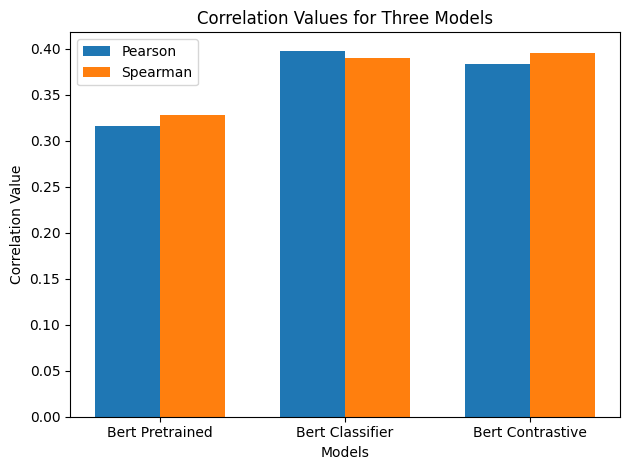

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Correlation values for the three models
models = ['Bert Pretrained', 'Bert Classifier', 'Bert Contrastive']
pearson_correlation = [results_from_pretrained[0], result_from_classification[0], result_from_contrastive[0]]
spearman_correlation = [results_from_pretrained[1], result_from_classification[1], result_from_contrastive[1]]

# Define the positions of the bars on the x-axis
x = np.arange(len(models))

# Bar width
width = 0.35

# Create the figure and axes
fig, ax = plt.subplots()

# Plot Pearson correlation values
pearson_bars = ax.bar(x - width/2, pearson_correlation, width, label='Pearson')

# Plot Spearman correlation values
spearman_bars = ax.bar(x + width/2, spearman_correlation, width, label='Spearman')

# Set labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Correlation Value')
ax.set_title('Correlation Values for Three Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()

# Analysis

The key difference between all of the methods applied to refining the sentence embeddings is in the approach to finetuning. Bert Pretrained doesn't do any fine-tuning, relying on the embeddings produced by the bert_tiny model. Meanwhile, BertClassifier and BertContrastive use the NLI dataset to fine-tune the embeddings produced by the model. BertClassifier does this by attempting to predict the relationship between sentence pairs via a softmax classifier, while BertContrastive does so using contrastive learning, where it attempts to increase the distance between anchor samples and negative samples and decrease the distance between anchor samples and positive samples in the embedding space.

Looking at the results, it appears that both BertClassifier and BertContrastive produce better pearson/spearman correlation scores than Bert Pretrained - indicating that fine-tuning was successful in refining the quality of the embeddings. It is interesting to note that BertClassifier and BertContrastive both produce similar pearson/spearman correlation scores. This indicates that both have similar levels of effectiveness for fine-tuning.

# **[OPTIONAL] Explore an alternative way to improve sentence encoder in terms of *performance* or *efficiency* [6 Points]**

Potential directions:
*   Improve the methodology to compute higher quality sentence embeddings  
*   Improve the efficiency during fine-tuning in terms of memory or training time
*   Use different machine learning methods that leverages other resources such as auxillary/teacher models
*   Use different datasets with other training objectives


**You can use any additional model, dataset, library or package for this part!!**

## My Approach - Paraphrase Identification
I attempt to improve performance by building upon the BertClassifier approach. The paper this approach was based on uses not only u, v and |u-v| as inputs to the classification layer, but also u \* v the element-wise product of u and v. Thus, I will take the same architecture used in part 3, but include u \* v in the input to the classification layer.

I will also train on a different dataset and with a different learning objective: the **Microsoft Research Paraphrase Corpus (msr-paraphrase-corpus)**. It contains two splits - **train** and **test** - in the form **(Quality, #1 ID, #2 ID, #1 String, and #2 String)**. Quality denotes whether #2 String is a paraphrase of #1 String, using 1 to signify it is and 0 to signify it isn't. Meanwhile the IDs are simply the IDs for each sentence. The split I will be using, train, contains **4076 samples**. Thus, the classification layer of my new BertClassifier will be trained to perform binary classification on u and v where u is #1 String and #2 String for all pairs in my dataset.

I will then evaluate the fine-tuned model on the test split of the sts dataset, like for parts 2-4.

## Load Corpus

In [ ]:
# WARNING - Requires download of dataset from https://www.microsoft.com/en-us/download/details.aspx?id=52398.
# Once you have done so, mount your google drive and upload the msr_paraphrase_train.txt file
# WARNING - Requires Windows machine to download. If this is not possible or there are any other issues
# email me at: jxyozu3@gmail.com and I can send the file over. I will attach the text file
# to the email containing the link to this colab.

from google.colab import drive

# Mount Drive
drive.mount('/content/drive')

# You will need to update 'corpus_path' to the appropriate file path for msr_paraphrase_train.txt
# i.e. corpus_path='/content/drive/MyDrive/path/to/msr_paraphrase_train.txt'
corpus_path = '/content/drive/MyDrive/Colab Notebooks/msr_paraphrase_train.txt'

# Initialize lists to store data
quality = []
id1 = []
id2 = []
string1 = []
string2 = []

# Open the corpus file and read its lines
with open(corpus_path, 'r', encoding='utf-8') as infile:
    lines = infile.readlines()

# Remove the first line (header) if it exists
if len(lines) > 0:
    lines.pop(0)

# Read data from the raw text file
for line in lines:
    parts = line.strip().split('\t')
    quality.append(int(parts[0]))
    id1.append(int(parts[1]))
    id2.append(int(parts[2]))
    string1.append(parts[3])
    string2.append(parts[4])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Construct Dataframe

In [ ]:
# Create a DataFrame
data = {
    'Quality': quality,
    '#1 ID': id1,
    '#2 ID': id2,
    '#1 String': string1,
    '#2 String': string2
}

df = pd.DataFrame(data)
df.head()

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,702876,702977,"Amrozi accused his brother, whom he called ""th...","Referring to him as only ""the witness"", Amrozi..."
1,0,2108705,2108831,Yucaipa owned Dominick's before selling the ch...,Yucaipa bought Dominick's in 1995 for $693 mil...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10, the ship's owners had published an..."
3,0,3344667,3344648,"Around 0335 GMT, Tab shares were up 19 cents, ...","Tab shares jumped 20 cents, or 4.6%, to set a ..."
4,1,1236820,1236712,"The stock rose $2.11, or about 11 percent, to ...",PG&E Corp. shares jumped $1.63 or 8 percent to...


## Preprocessing Functions

In [ ]:
def load_msr_dataset(dataframe):
  #DONE: add code to load MSR dataset in required format

  # Defining the columns we wish to select. In this case, we want all the
  # sentence pairs for the 'train' split, so we need columns split, sentence1,
  # sentence2 and label
  selected_columns = ['Quality', '#1 String', '#2 String']

  filtered_dataframe = dataframe[selected_columns]

  # Initialise dictionary for storing the training samples
  msr_samples = {'train': []}

  # Iterate through the rows of the DataFrame
  for index, row in filtered_dataframe.iterrows():
    sentence1 = row['#1 String']
    sentence2 = row['#2 String']
    label = row['Quality']

    # Create a tuple in the format (sentence1, sentence2, label)
    sample = (sentence1, sentence2, label)

    # Append the tuple to the 'train' key in the dictionary
    msr_samples['train'].append(sample)

  return msr_samples

# A helper function passed to the dataloader to create batches in the form
# (batch_size, sequence_length) for sentence1_input_ids, sentence1_attention_mask,
# sentence2_input_ids and sentence2_attention_mask. The labels are stored in the
# shape (batch_size, 1)
def custom_collate_fn_msr(batch):
  # 'batch' is the list of dictionaries for a given batch

  # Extract individual lists of input_ids and attention_mask for each sample in the batch
  sentence1_input_ids = [sample['sentence1_input_ids'][0] for sample in batch]
  sentence1_attention_mask = [sample['sentence1_attention_mask'][0] for sample in batch]
  sentence2_input_ids = [sample['sentence2_input_ids'][0] for sample in batch]
  sentence2_attention_mask = [sample['sentence2_attention_mask'][0] for sample in batch]

  # Convert input_ids and attention_mask to tensor
  sentence1_input_ids = torch.tensor(sentence1_input_ids)
  sentence1_attention_mask = torch.tensor(sentence1_attention_mask)
  sentence2_input_ids = torch.tensor(sentence2_input_ids)
  sentence2_attention_mask = torch.tensor(sentence2_attention_mask)

  # Extract label for each sentence pair
  labels = [torch.tensor(sample['label']).float() for sample in batch]

  # Construct label matrix
  labels_matrix = torch.stack(labels, dim=0).view(-1, 1).float()

  return {
      'sentence1_input_ids': sentence1_input_ids,
      'sentence1_attention_mask': sentence1_attention_mask,
      'sentence2_input_ids': sentence2_input_ids,
      'sentence2_attention_mask': sentence2_attention_mask,
      'label': labels_matrix
  }

## Model Creation

In [ ]:
class BertClassifierMLPForMSR(nn.Module):
  """
  Multi-Layer Perceptron (MLP) module used within BertClassifierMSR.
  The MLP consists of one hidden layer, which has been defaulted to contain 512
  hidden units in line with the MLP in the original BertClassifier.

  Using GELU in between the layers, and defaulting num_classes to 1 for binary
  classification
  """

  def __init__(self, hidden_size, intermediate_size=512, num_classes=1):
    """
    Initialize a Multi-Layer Perceptron (MLP) module.

    :param hidden_size: The feature dimension of a given sentence embedding.
    :param intermediate_size: The dimension of the intermediate (hidden) layer.
    :param num_classes: The number of classes. Corresponds with the dimensions
                        of the output layer.
    """

    super(BertClassifierMLPForMSR, self).__init__()
    # Must multiply hidden_size by four to ensure that we account for
    # u, v, |u - v| and u * v, all of which will have feature dimensions of hidden_size
    self.dense_expansion = nn.Linear(hidden_size * 4, intermediate_size)
    self.dense_contraction = nn.Linear(intermediate_size, num_classes)

  def forward(self, x):
    """
    Forward pass of the MLP module.

    :param x: The input tensor. We concatenate the embeddings for
              u, v, |u - v| and u * v, so will be of size (batch_size, hidden_size * 4)

    :return: The output tensor of size (batch_size, num_classes) after applying the MLP.
             The logits for each class will be stored in the columns
    """

    x = self.dense_expansion(x)
    x = self.dense_contraction(gelu(x))
    return x

class BertClassifierMSR(nn.Module):
  #DONE: add __init__ to construct BERTClassifier based on given pretrained BERT
  #DONE: add code for forward pass that returns the loss value
  #DONE: add aditional method if required
  def __init__(self, config_dict, bert_path):
    """
    Initialize the BertClassifier for MSR.

    :param config_dict: A dictionary containing BERT configuration settings.
    :param bert_path: Path to pretrained Bert weight file
    :param num_classes: Number of output classes.
    """

    super(BertClassifierMSR, self).__init__()
    self.config = Config.from_dict(config_dict)

    # Load Bert
    self.bert = Bert(config_dict).load_model(bert_path)

    # Add a linear layer for classification
    self.num_classes = 1
    self.classifier = BertClassifierMLPForMSR(self.config.hidden_size, self.num_classes)

  def forward(self, u_input_ids, u_attention_mask, v_input_ids, v_attention_mask, labels=None):
    """
    Forward pass of the BertClassifier for MSR.

    :param u_input_ids: The input token IDs of shape (batch_size, sequence_length) for u.
    :param u_attention_mask: The attention mask tensor of shape (batch_size, sequence_length) for u.
    :param v_input_ids: The input token IDs of shape (batch_size, sequence_length) for v.
    :param v_attention_mask: The attention mask tensor of shape (batch_size, sequence_length) for v.
    :param labels: The labels for the sentence pair u,v of shape (batch_size, 1)

    :return: The logits (raw scores) for each class if no labels are provided, but
             a tuple in the form (logits, loss) if they are. The logits will be
             in a matrix of shape (batch_size, 1)
    """

    # Get BERT's pooled output for u and v
    _, u_pooled_output = self.bert(u_input_ids, u_attention_mask)
    _, v_pooled_output = self.bert(v_input_ids, v_attention_mask)

    # Compute |u-v|
    abs_u_minus_v = torch.abs(u_pooled_output - v_pooled_output)

    # Compute u * v
    u_times_v = u_pooled_output * v_pooled_output

    # Construct input for classifier by concatenating u, v, |u-v| and u*v
    # along the feature dimension
    classifier_input = torch.cat((u_pooled_output,
                                  v_pooled_output,
                                  abs_u_minus_v,
                                  u_times_v),
                                 dim=-1)

    # Do forward pass through the classifier
    logits = self.classifier(classifier_input)

    # Return logits & loss if labels are provided. Just logits if not
    if labels is not None:
      loss = F.binary_cross_entropy_with_logits(logits, labels)
      return (logits, loss)
    return logits

## Training

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 10 # Greater number of epochs since dataset is fairly small
batch_size = 8
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#INFO: load msr dataset
msr_dataset = load_msr_dataset(df)

#INFO: tokenize dataset
tokenized_train = tokenize_sentence_pair_dataset(msr_dataset['train'], tokenizer, max_length=128)

#INFO: generate train_dataloader
# Here I pass a custom collation function to the dataloader to ease construction of matrices for u and v
# in the shape (batch_size, sequence_length)
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn_msr)

#DONE: Create a BertClassifierMSR with required parameters
bert_classifier_msr = BertClassifierMSR(config_dict=bert_config, bert_path=bert_path)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_classifier_msr.parameters(), lr=5e-5)
train_loop(bert_classifier_msr, optimizer, train_dataloader, num_epochs, device)

Epoch [1/10]
Train Loss: 0.6385
Epoch [2/10]
Train Loss: 0.6315
Epoch [3/10]
Train Loss: 0.6307
Epoch [4/10]
Train Loss: 0.6313
Epoch [5/10]
Train Loss: 0.6315
Epoch [6/10]
Train Loss: 0.6305
Epoch [7/10]
Train Loss: 0.6316
Epoch [8/10]
Train Loss: 0.6312
Epoch [9/10]
Train Loss: 0.6311
Epoch [10/10]
Train Loss: 0.6310


## Evaluation

In [ ]:
#DONE: run evaluation loop
model_msr = bert_classifier_msr.bert
result_from_msr = eval_loop(model_msr, test_dataloader, device)
print(f'\nPearson correlation: {result_from_msr[0]:.2f}\nSpearman correlation: {result_from_msr[1]:.2f}')


Pearson correlation: 0.36
Spearman correlation: 0.36


## Results

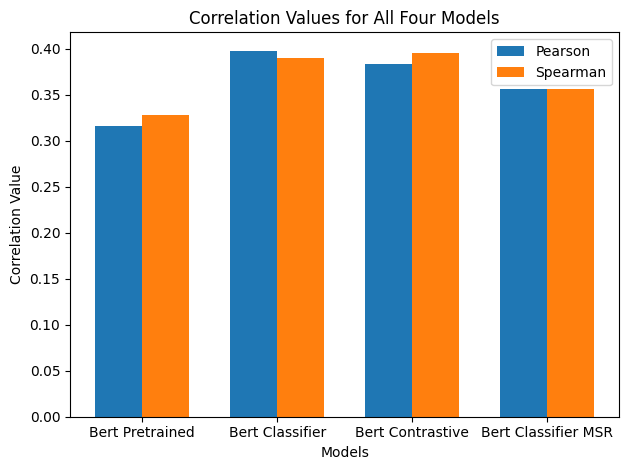

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Correlation values for the four models
models = ['Bert Pretrained', 'Bert Classifier', 'Bert Contrastive', 'Bert Classifier MSR']
pearson_correlation = [results_from_pretrained[0], result_from_classification[0], result_from_contrastive[0], result_from_msr[0]]
spearman_correlation = [results_from_pretrained[1], result_from_classification[1], result_from_contrastive[1], result_from_msr[1]]

# Define the positions of the bars on the x-axis
x = np.arange(len(models))

# Bar width
width = 0.35

# Create the figure and axes
fig, ax = plt.subplots()

# Plot Pearson correlation values
pearson_bars = ax.bar(x - width/2, pearson_correlation, width, label='Pearson')

# Plot Spearman correlation values
spearman_bars = ax.bar(x + width/2, spearman_correlation, width, label='Spearman')

# Set labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Correlation Value')
ax.set_title('Correlation Values for All Four Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()

## Analysis

From the results, we can see that when comparing this model to the models created in parts 2-4, this model exhibits superior performance only to the baseline bert model (Bert Pretrained). This can likely be attributed to the fact that the MSR dataset is very small compared to the size of the datasets used to train Bert Classifier and Bert Contrastive. However, the fact that this model shows superior performance to a baseline pretrained Bert model indicates that this architecture was in some way successful in refining the embeddings produced by the model.

The task of identifying paraphrases is similar to the task the model is evaluated on (similarity scores) in that the model must develop an understanding of the semantic meaning of a given sentence, so these results are in line with what one might expect. Perhaps with more data, this architecture has the potential to produce results at the same level as those of BertClassifier and BertContrastive.